**Avetissements** : 
- L'affichage des visuels et la fonctionnalité des liens est optimale sur le navigateur **Chrome**.
- La source principale de cette analyse, dataset de musées, est **fortement incomplète** bien que provenant du site du gouvernement. L'analyse de la répartition des musées sur le territoire français n'est donc pas des plus justes. De plus, on trouve quelque fois des **données érronées**, telles que le musée du Quai Branly qui apparait deux fois : une fois à son emplacement habituel et une seconde fois à l'adresse du Centre sportif Émile Anthoine.

# Table des matières

* [Description du Dataset](#description)
* [Data cleaning](#cleaning)
    - [Travail préliminaire](#travail-preliminaire)
    - [Informations inutiles](#informations-inutiles)
    - [Valeurs manquantes](#valeurs-manquantes)
    - [Valeurs érronées](#valeurs-erronees)
    - [Ajout d'informations](#ajout-informations)
* [Analyse visuelle](#analyse-visuelle)
    - [Nombre de musee](#nombre-musee)
    - [Tendance générale](#tendance-generale)
    - [Nationalité des musées](#nationalite)
    - [Repartition des musées français](#repartition-musees-france)
    - [Fréquentation des musées français](#frequentation-musees-france)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import geopandas as gpd # Pour créer une map
from geopandas.tools import geocode # Pour retrouver des coordonnées GPS au lieu d'utiliser une API
import folium # Carte interactive
from folium import Marker
from folium.plugins import MarkerCluster, HeatMap # Pour grouper en cluster les musées sur carte interactive

Chaque année est contenue dans un dataset. Nous avons donc 6 datasets dont les colums sont exactement les mêmes.

In [2]:
############# Dataset fréquentation des musées #############
folder_filepath = "../input/frequentationmuseesdefrance20132018"
all_files = glob.glob(folder_filepath + "/*.csv")

liste = []

for filename in all_files:
    annee = pd.read_csv(filename, index_col=None, header=0)
    liste.append(annee)
    
df = pd.concat(liste, axis=0, ignore_index=True)

############# Dataset des communes française #############
communes_francaises = gpd.read_file('../input/communes-francaises-shapes/communes-20210101.shp')

<a id="description"></a>
# Description du dataset

Ce dataset a été trouvé sur le [site du gouvernement](https://www.data.gouv.fr/fr/datasets/frequentation-des-musees-de-france/). Il est découpé en plusieurs fichier csv : un par année.[](http://)

In [3]:
print("Nombre de ligne : ", df.shape[0])
print("Nombre de colonne : ", df.shape[1])

Nombre de ligne :  7138
Nombre de colonne :  22


Aperçu du dataset :

In [4]:
df.head()

,id,osm_id,name,number,street,postal_code,city,country,country_code,status,...,website,phone,fax,year,payant,gratuit,date,tags,description,stats
0,0105302,NaN,Musée Départemental des Pays De l'Ain,NaN,NaN,NaN,BOURG-EN-BRESSE,France,fr,open,...,NaN,NaN,NaN,2018,0.0,0.0,01/02/2003,label:musee de france,NaN,NaN
1,0119201,1.357668e+09,Musée Archéologique,NaN,Place de l'Église,01580,Izernore,France,fr,open,...,NaN,NaN,NaN,2018,1644.0,2174.0,01/02/2003,label:musee de france,NaN,NaN
2,0128301,1.536397e+09,Musée du Peigne et de la Plasturgie,NaN,Rue Capitaine Montreal,01100,Veyziat,France,fr,open,...,NaN,NaN,NaN,2018,1509.0,2397.0,01/02/2003,label:musee de france,NaN,NaN
3,0319002,NaN,Centre National du Costume de Scène et de la S...,NaN,NaN,NaN,MOULINS,France,fr,open,...,NaN,NaN,NaN,2018,72733.0,21431.0,23/10/2009,label:musee de france,NaN,NaN
4,0701001,4.424167e+09,Musée Vivarois César Filhol,15,Rue Jean-Baptiste Bechetoille,07100,Annonay,France,fr,closed,...,NaN,NaN,NaN,2018,0.0,0.0,01/02/2003,label:musee de france,NaN,NaN


<a id="cleaning"></a>
# Cleaning

<a id="travail-preliminaire"></a>
## Travail préliminaire

Un premier travail de data cleaning a été effectué avec un script python car le dataset original présentait un petit coquille : une seule colonne **stat** (données les plus précieuse de ce dataset) était présente avec pour format du "semi-colon separeted file".
Le script remplace toutes les occurences de "payant:" par "", ";gratuit:" par "," et ";label-date:". Lors de ces remplacement, on s'occupe donc de transformer les semi-colons en comma. Enfin, le script remplace "stats" dans le header par "payant,gratuit,date".

<a id="informations-inutiles"></a>
## Informations inutiles

On drop les colonnes de données qui ne nous interessent pas :
- website
- phone
- fax
- date
- tags
- description

In [5]:
df = df.drop(["website","phone","fax","date","tags","description","stats"],axis=1)

<a id="valeurs-manquantes"></a>
## Valeurs manquantes

In [6]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

id                 0
osm_id          1507
name               0
number          5922
street          1671
postal_code     1583
city               6
country            0
country_code       0
status             0
lat             1507
lon             1507
year               0
payant             2
gratuit            2
dtype: int64


On élimine toutes les lignes dont la valeur NaN ne peut pas être remplacée ainsi que les musées ayant fait 0 entrée gratuite **ET** 0 entrée payante. On part du principe qu'il est possible qu'un musée soit à 100% gratuit ou payant.

In [7]:
print("Nombre de ligne avant suppression: ", df.shape[0])
df = df[df.id.notna()]
df = df[df.year.notna()]
df = df[df.payant.notna() & df.gratuit.notna()]
df = df[(df.payant != 0.0) | (df.gratuit != 0.0)]
print("Nombre de ligne après suppression : ", df.shape[0])

Nombre de ligne avant suppression:  7138
Nombre de ligne après suppression :  6113


Pour les codes postaux absents, nous les remplaçons grâce à une [API](https://geo.api.gouv.fr) qui transforme un nom de ville en code postal.
Edit: limite de 50 requetes secondes, il serait plus interessant de faire ce processus en même temps que la correction de la colonne stats.

On vérifie le type de donnée qui se trouve dans notre base de donnée :[](http://)

In [8]:
df.dtypes

id               object
osm_id          float64
name             object
number           object
street           object
postal_code      object
city             object
country          object
country_code     object
status           object
lat             float64
lon             float64
year              int64
payant          float64
gratuit         float64
dtype: object

Il apparait que l'id est composé du numéro de département. Nous avons donc des lettres pour les musées corse (2A, 2B). Il serait possible de remplacer ces valeurs afin de pouvoir traiter l'id comme une valeur numérique mais je n'en vois pas l'interet pour ce projet.

Cependant, nous allons convertir "payant" et "gratuit" en int.

In [9]:
df.payant = df.payant.astype(int)
df.gratuit = df.gratuit.astype(int)

<a id="valeurs-erronees"></a>
## Valeurs érronées
L'on constate la présences de données données érronées. Ainsi, on retrouve le musée du Quai Branly à deux adresses et coordonnées GPS différentes, ces données ne sont pas corrompues car sont cohérentes entre elles mais ne sont pas valides. 

In [10]:
museeQuaiBranly = df[df['name'].str.contains("Branly")].drop(['country', 'country_code','status', 'payant', 'gratuit'],axis=1)
print(museeQuaiBranly)

           id       osm_id                                   name number  \
599   7510709   17954721.0  Musée du Quai Branly - Jacques Chirac     37   
2209  7510709  151074455.0                   Musée du Quai Branly    NaN   
2977  7510709   17954721.0  Musée du Quai Branly - Jacques Chirac     37   
3664  7510709   17954721.0  Musée du Quai Branly - Jacques Chirac     37   
5574  7510709  151074455.0                   Musée du Quai Branly    NaN   
6531  7510709  151074455.0                   Musée du Quai Branly    NaN   

                    street postal_code   city        lat       lon  year  
599            Quai Branly       75007  Paris  48.860994  2.297970  2018  
2209  Rue de la Fédération       75015  Paris  48.854737  2.289778  2016  
2977           Quai Branly       75007  Paris  48.860994  2.297970  2017  
3664           Quai Branly       75007  Paris  48.860994  2.297970  2013  
5574  Rue de la Fédération       75015  Paris  48.854737  2.289778  2014  
6531  Rue de la F

<a id="ajout-informations"></a>
## Ajout d'informations

Nous allons rajouter une colonne "Total" ayant pour valeur les entrées gratuites additionnées aux payantes :

In [11]:
df['total'] = df.gratuit + df.payant
df.head()

,id,osm_id,name,number,street,postal_code,city,country,country_code,status,lat,lon,year,payant,gratuit,total
1,0119201,1.357668e+09,Musée Archéologique,NaN,Place de l'Église,01580,Izernore,France,fr,open,46.220134,5.554812,2018,1644,2174,3818
2,0128301,1.536397e+09,Musée du Peigne et de la Plasturgie,NaN,Rue Capitaine Montreal,01100,Veyziat,France,fr,open,46.260779,5.646525,2018,1509,2397,3906
3,0319002,NaN,Centre National du Costume de Scène et de la S...,NaN,NaN,NaN,MOULINS,France,fr,open,NaN,NaN,2018,72733,21431,94164
5,0731601,6.833278e+07,Musée et Site Archéologiques,NaN,Rue des Ruines,07130,Soyons,France,fr,open,44.887927,4.850776,2018,12670,2040,14710
6,7428102,5.537445e+09,Musée du Chablais,2,Rue Michaud,74200,Thonon-les-Bains,France,fr,open,46.373593,6.478211,2018,1179,1656,2835


In [12]:
# Fonction utilisant geocode pour recuperer les coordonnées GPS
# Amélioration possible : faire ce travail en amont avec un script Python afin de ne pas répéter
# l'opération à chaque run de ce notebook
#def fill_coordinates(row):
#    try:
 #       point = geocode(row, provider='nominatim').geometry.iloc[0] # On prends le premier résultat (pas forcément le bon ...)
 #       return pd.Series({'Latitude': point.y, 'Longitude': point.x})
  #  except:
   #     return None
    
#########################################   A faire en dehors de ce notebook : Unacceptable Use (Nominatim) ##########################################################
# On récupère les index des lignes dont les coordonnées sont manquantes
# en vérifiant que la ville est tout de même spécifiée
#missing_coord = df.index[((df.lat.isnull() | df.lon.isnull()) & df.city.notnull())]
    
#for index in missing_coord:
#    df.loc[index][['lat','lon']] = df.apply(lambda x: fill_coordinates(x['city']), axis=1)
    
#df.head()
# OU
#def my_geocoder(row):
#    point = geocode(row, provider='nominatim').geometry[0]
 #   return pd.Series({'Longitude': point.x, 'Latitude': point.y})
#
#rows_with_missing = df[((df.lat.isnull() | df.lon.isnull()) & df.city.notnull())]
#temp = rows_with_missing.apply(lambda x: my_geocoder(x['city']), axis=1)
#df.update(temp)

<a id="analyse-visuelle"></a>
# Analyse visuelle
<a id="nombre-musee"></a>
## Nombre de musée

In [13]:
nb_musee_par_annee = df.groupby('year').count()['id']
print("Evolution du nombre de musées",nb_musee_par_annee)

Evolution du nombre de musées year
2013    1007
2014    1007
2015     997
2016    1028
2017    1048
2018    1026
Name: id, dtype: int64


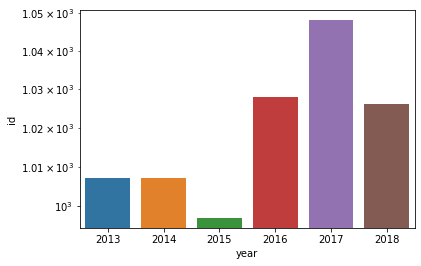

In [14]:
plot_nb_musee = sns.barplot(x=nb_musee_par_annee.index, y=nb_musee_par_annee)
# Je le mets en échelle logarithmique pour avoir une meilleure visibilité 
plot_nb_musee.set_yscale("log")

On remarque qu'il n'y a pas une evolution flagrante du nombre de musée (amplitude de 1048 - 997 = 51, tout de même environ 5% de notre effectif de musées). Nous pourrons donc comparer le nombre d'entrées annuelles par années sans avoir recours à une moyenne en fonction du nombre
<a id="tendance-generale"></a>
## Tendance générale du nombre d'entrée

On va regarder le nombre d'entrée par année :

In [15]:
# On regroupe par année en faisant la somme
somme_par_annee = df.groupby('year').sum()
somme_par_annee = somme_par_annee.drop(['lat','lon'],axis=1)
somme_par_annee

,osm_id,payant,gratuit,total
year,,,,
2013,1.234124e+12,28502992,35930635,64433627
2014,1.199394e+12,36650770,28498890,65149660
2015,1.207559e+12,36244518,26167070,62411588
2016,1.262356e+12,33913562,26360136,60273698
2017,1.266246e+12,26332871,37218636,63551507
2018,1.227269e+12,37692562,28459101,66151663


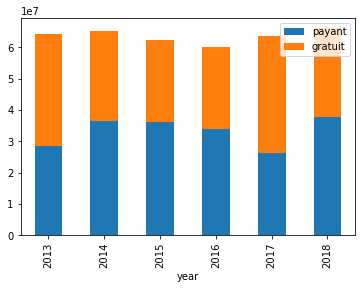

In [16]:
axis = somme_par_annee[["payant", "gratuit"]].plot(kind="bar", stacked=True)

Pas très parlant, puisque d'une année sur l'autre, l'évolution n'est pas très visible. On pourrait utiliser une echelle logarithmique mais on va préfèrer générer un tableau qui présentera les variations en pourcentage d'une année à l'autre.

Voici un tableau qui présente les variations, en pourcentage, par rapport à N-1 :

In [17]:
# fonction anonyme pour calcul (VA-VD)/VD
# shift(1) prends la valeur suivante
evo_somme_par_annee = somme_par_annee.apply(lambda x: ((x - x.shift(1))/x)*100)
# Pour enlever le premier row qui n'a aucune évolution par rapport à N-1
evo_somme_par_annee = evo_somme_par_annee.iloc[1:]
# On arrondi
evo_somme_par_annee = evo_somme_par_annee.round(decimals=2)
evo_somme_par_annee

,osm_id,payant,gratuit,total
year,,,,
2014,-2.90,22.23,-26.08,1.10
2015,0.68,-1.12,-8.91,-4.39
2016,4.34,-6.87,0.73,-3.55
2017,0.31,-28.79,29.17,5.16
2018,-3.18,30.14,-30.78,3.93


<AxesSubplot:xlabel='year', ylabel='% par rapport à N-1'>

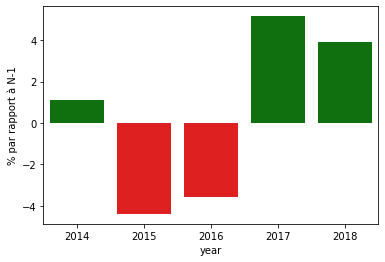

In [18]:
evo_somme_par_annee = evo_somme_par_annee.rename(columns={'total': '% par rapport à N-1'})

# Afin d'avoir les evolutions négatives en rouge et les positives en vert
couleurs = ['green' if (x >= 0) else 'red' for x in evo_somme_par_annee['% par rapport à N-1'] ]
# https://stackoverflow.com/questions/31074758/how-to-set-a-different-color-to-the-largest-bar-in-a-seaborn-barplot

sns.barplot(x=evo_somme_par_annee.index, y=evo_somme_par_annee['% par rapport à N-1'], palette=couleurs)

On lit desormais un peu mieux les évolutions de fréquentation des ces musées.
Ainsi, nous pouvons **attribuer cette forte diminution aux attentats de janvier 2015**, puis dans une moindre mesure juillet 2016 et à la mise en place du **plan vigipirate**. Il faut tout de même rappeler qu'il y a 20 musées de moins en 2015 qu'en 2014 et 31 musées de plus en 2016 par rapport à 2015. Il serait intéressant de calculer une moyenne à l'année : nombre total de visiteur / nombre total de musée.
<a id="nationalite"></a>
## Nationalité des musées

In [19]:
nb_musee_pays = df.groupby('country_code').count()['id']
nb_musee_pays

country_code
be      18
fr    6075
ga       3
it       6
us      11
Name: id, dtype: int64

On constate qu'il y a beacoup plus de musée français que d'autres pays.
On ne pourra donc **pas faire d'analyses basées sur les différences entre pays** puisque pas assez d'information.

<a id="repartition-musees-france"></a>
## Répartition des musées français

1199  musées ont été abandonnés car coordonnées manquantes


<AxesSubplot:>

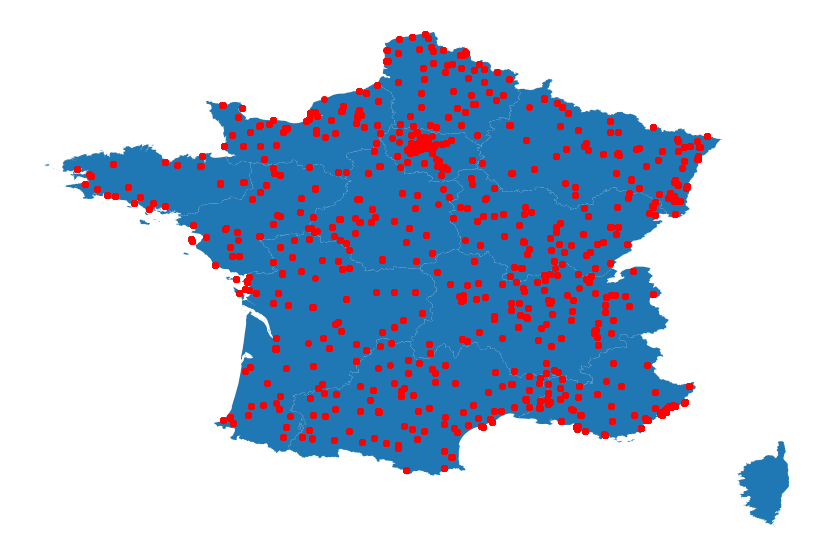

In [20]:
# OpenStreetMap, DGFiP, 2 janvier 2018, sous licence ODbL
france_shape = gpd.read_file("../input/france-shape/regions-20180101.shp")

# On garde uniquement la France métropolitaine
france_shape = france_shape.drop([0,2,7,11,13])
france = france_shape.plot(figsize=(15,10))
france.axis('off')

# Filtrage du dataset pour garder uniquement les musées français METROPOLITAINS
musee_fr = df.loc[df['country_code'] == 'fr']

# On drop les musées aux coordonnées manquantes
print(musee_fr['lat'].isnull().sum(), " musées ont été abandonnés car coordonnées manquantes")
musee_fr = musee_fr.dropna(subset=['lat', 'lon'])

# Étant donné qu'il nous manque quelque code postaux, pour retirer les DOM-TOM, on va se baser sur les coordonées GPS.
# On retiendra uniquement les coordonnées comprisent dans le périmètre 
# de la France métropolitaine, ou plus grossièrement d'un carré autour de la France.
# De façon plus élégante, on aurait pu utiliser le spatial join gpd.sjoin(musee_fr, france)
lat = [42.25, 51.1] # 42.25 => Sud de Perpignan, 51.1 => Nord de Dunkerque
lon = [-5.0, 8.5] # -5 => Ouest de la Bretagne, 8.5 => Est de l'Alsace-Lorraine
musee_fr = musee_fr.loc[(musee_fr.lon > lon[0]) & (musee_fr.lon < lon[1])]
musee_fr = musee_fr.loc[(musee_fr.lat > lat[0]) & (musee_fr.lat < lat[1])]

# On transforme le dataset pandas en geopandas
gdf = gpd.GeoDataFrame(
    musee_fr, geometry=gpd.points_from_xy(musee_fr.lon, musee_fr.lat))

# On peut dessiner les points
gdf.plot(color='red', ax=france)


In [21]:
########################## Diminuer le nombre de point à afficher, inutile  dans notre cas #################################
# A ce stade, si charge de travaille est trop importante, il faut encore réduire le nombre de ligne
# Pour ça, on peut grouper par nom de musée, par code postal, par ville..
# On pourrait se baser sur les deux premiers chiffres du code postal afin de grouper par département,
# mais je vais préferer regrouper les musées proches (en regardant la latitude/longitude).
# Il serait trop couteux de calculer la distance euclidienne entre tous les points pour regrouper les musées les plus proches

# La distance entre chaque degré de latitude, ou longitude, est de 110km
# on va donc arrondir toutes nos coordonnées au dixième inferieur de degré pour regrouper les musées dans un rayons de 11km

## musee_fr['lat'] = musee_fr['lat'].round(1)
## musee_fr['lon'] = musee_fr['lon'].round(1)

## print("Nombre de ligne avant le groupage : ", musee_fr.shape[0])
## musee_fr = musee_fr.groupby(['lat','lon'])
## print("Nombre de ligne après le groupage : ", len(musee_fr))
###########################################################################################################################

**Amélioration possible** : remplir les coordonnées GPS (lon/lat) de toutes les lignes dont elles sont absentes grâce au nom de la ville.

In [22]:
distinct_musee_fr = musee_fr # pour ne pas afficher 6 fois le même musée (qui apparait une fois par année)
# D'abord on va grouper par ID mais ça ne sera pas suffisant puisqu'il manque 1507 Id (en tout cas, dans la version
# actuelle du dataset), alors on groupera par nom pour etre certain de limiter au maximum
print("Nombre de musées avant le drop duplicate sur l'id : ", len(distinct_musee_fr))
distinct_musee_fr = distinct_musee_fr.drop_duplicates(subset=['osm_id'])
distinct_musee_fr = distinct_musee_fr.drop_duplicates(subset=['id'])
print("Nombre de musées après le drop duplicate sur l'id mais avant drop sur nom: ", len(distinct_musee_fr))
# lower car certaines villes tel que Bouxwiller possédent deux entrée différente pour le même musée :
# "Musée de Bouxwiller et du Pays de Hanau" et "Musée de Bouxwiller et du pays de Hanau" (p de pays maj/min)
# on confirme en regardant la ville, car deux musées peuvent avoir le même nom mais être deux musées différents
distinct_musee_fr['name'] = distinct_musee_fr['name'].str.lower()
distinct_musee_fr = distinct_musee_fr.drop_duplicates(subset=['name', 'city']) 
print("Nombre de musées après le drop duplicate sur nom: ", len(distinct_musee_fr))

carte_interactive = folium.Map(location=[46.23,2.2], zoom_start=6)
HeatMap(data=distinct_musee_fr[['lat', 'lon']], radius=20).add_to(carte_interactive)
# Add points to the map
cluster = MarkerCluster()
for index, row in distinct_musee_fr.iterrows(): # index est inutile mais j'ai une erreur sinon
    cluster.add_child(Marker([row['lat'], row['lon']]))
carte_interactive.add_child(cluster)

Nombre de musées avant le drop duplicate sur l'id :  4766
Nombre de musées après le drop duplicate sur l'id mais avant drop sur nom:  824
Nombre de musées après le drop duplicate sur nom:  824


Nous constatons que la pluspart des musées se situent dans les **grandes villes**, ce qui n'est pas très étonnant.

**Amélioration possible** : Calculer un écart moyen des musées d'une ville et le comparer à la superficie afin de constater une bonne, ou mauvaise, répartition des musées sur le territoire.

Etablissons alors un classement des 5 villes ayant le plus de musées : 

Text(0, 0.5, 'Nombre de musée')

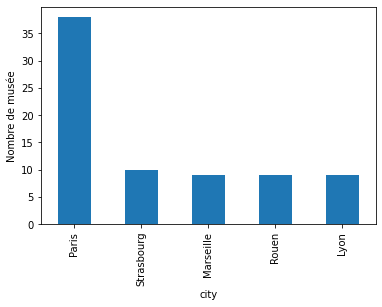

In [23]:
musee_par_ville = distinct_musee_fr.groupby('city').count()['id'].sort_values(ascending = False)
musee_par_ville.head().plot(kind="bar").set_ylabel('Nombre de musée')

Cependant, une grande ville a plus de chance d'avoir une quantité importante de musée.
Nous allons donc faire à nouveau ce classement mais en prenant **en compte la superficie de la ville**.

In [24]:
# On fait appel à un nouveau dataset
communes_francaises.head()

# On capitalise les noms de ville pour être certain de travailler avec le même format
communes_francaises.nom = communes_francaises['nom'].str.capitalize()
musee_par_ville.city = musee_par_ville.index.str.capitalize() # city est l'index

# On renommer pour pouvoir merge
communes_francaises = communes_francaises.rename(columns={"nom": "city"})

Ce dataset demande un allègement car certaines villes portent le même nom et je ne dispose pas de tous les codes postaux pour distinguer les homonymes. Ainsi, il y a un Castres dans le Tarn et un dans l'Ainse, situation équivalente pour Péronne :

In [25]:
print(communes_francaises[communes_francaises['city'].isin(['Castres', 'Péronne'])].drop(['geometry'], axis=1))

       insee     city                    wikipedia  surf_ha
18028  81065  Castres                   fr:Castres   9841.0
21255  71345  Péronne  fr:Péronne (Saône-et-Loire)   1057.0
33000  80620  Péronne           fr:Péronne (Somme)   1423.0
33049  02142  Castres           fr:Castres (Aisne)    577.0


**Amélioration possible** : completer les codes postaux grâce à la ville + nom de rue (afin de pas donner le code postal de Castres (81) à  Castres (02) par erreur si l'un d'eux venait à manquer) dans le dataset `frequentationmusee...`. Ainsi, on garderait le code postal dans `musee_par_ville` et au moment de merge avec `communes_francaises`, on opèrerait avec le nom de ville **ET** les deux premiers chiffres du code postal.
Pour ce notebook, nous supprimerons juste la ville la plus petite qui, statistiquement, a moins de chance d'avoir un musée qu'une autre ville du même nom.

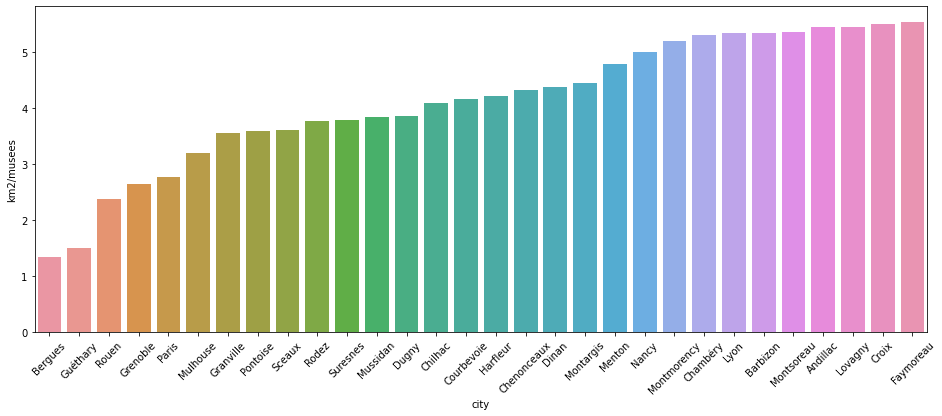

In [26]:
# On merge les villes avec leur superficie
musee_par_ville_superficie = musee_par_ville.to_frame().merge(communes_francaises, on="city")

# Pour les villes homonymes comme Castres, on va enlever la plus petite des deux
# on va donc sort dans l'ordre croissant de surface puis utiliser drop_duplicates en gardant le dernier (le plus grand)
musee_par_ville_superficie = musee_par_ville_superficie.sort_values('surf_ha')
musee_par_ville_superficie = musee_par_ville_superficie.drop_duplicates(subset=['city'], keep='last')
# print(musee_par_ville_superficie[musee_par_ville_superficie['city'].isin(['Castres', 'Péronne'])].drop(['geometry'], axis=1))

#musee_par_ville_superficie = communes_francaises.rename(columns={"id": "nb_musee"})
musee_par_ville_superficie = musee_par_ville_superficie.drop(['insee','wikipedia'], axis=1)

# On crée une nouvelle colonne qui présentera le nombre de musée au kilomètre carré
musee_par_ville_superficie['km2/musees'] = (musee_par_ville_superficie.surf_ha / 100) / musee_par_ville_superficie.id

# On trie notre dataframe en fonction
musee_par_ville_superficie = musee_par_ville_superficie.sort_values('km2/musees')

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="city", y="km2/musees",data=musee_par_ville_superficie.head(30))

for item in ax.get_xticklabels():
    item.set_rotation(45)

On constate que le classement a bien changé ! Paris est desormais 25ème de ce classement. Cependant, il y a beaucoup de ville possédant un unique musée, voir deux. 

In [27]:
print(musee_par_ville_superficie['id'].value_counts().head(3))

1    295
2     39
3     17
Name: id, dtype: int64


En effet, il y a `295` villes ayant un unique musée et `39` en possèdent deux.
Afin d'avoir une analyse plus pertinente, nous allons **supprimer les villes n'ayant qu'un seul musée**.
De plus, nous allons afficher le nombre de musée que possède la ville sur la barre de cette dernière.

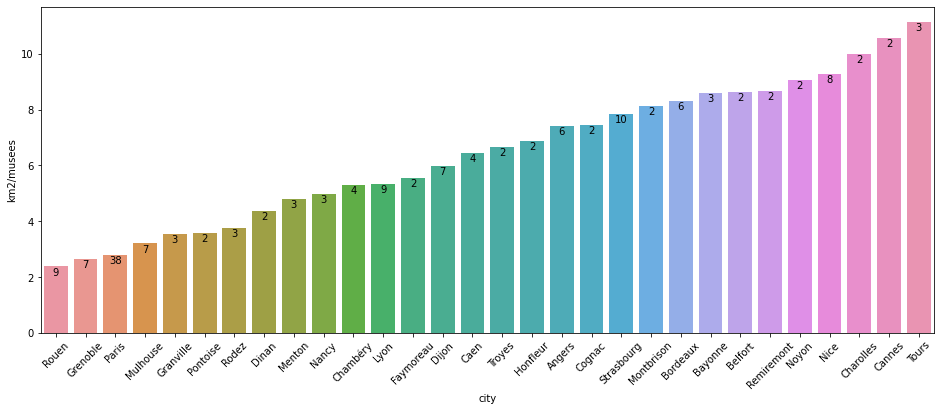

In [28]:
villes_avec_au_moins_2_musees = musee_par_ville_superficie[musee_par_ville_superficie['id'] > 1]

# Trie
villes_avec_au_moins_2_musees = villes_avec_au_moins_2_musees.sort_values('km2/musees')

top_30 = villes_avec_au_moins_2_musees.head(30)
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="city", y="km2/musees",data=top_30)

# Pour incliner le nom des ville
for item in ax.get_xticklabels():
    item.set_rotation(45)

# x pour se déplacer sur l'axe des abcisses et positionner le nombre de musée sur la barre 
x = 0
# Pour ajouter le nombre de musée sur la barre
# source : https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
for index, row in top_30.iterrows():
    ax.text(x, row['km2/musees']-0.3, row.id, color='black', ha="center")
    x = x + 1

Outre les petites villes possédant uniquement deux musées, l'on constate que la concentration de musée est assez élevée à Tour, Nice, Bayonne ou encore Bordeaux. Il pourrait être intéressant de **croiser ces données avec des informations démographiques ou économiques** afin de déceler des corrélations entre le nombre de musée et le taux d'échec scolaire, par exemple.

In [29]:
def print_stats_ville(ville):
    surface = communes_francaises[communes_francaises['city'] == ville]['surf_ha'].values[0] /100
    musees = distinct_musee_fr[distinct_musee_fr['city'] == ville]['name'].values
    musees_par_km2 = musee_par_ville_superficie[musee_par_ville_superficie['city'] == ville]['km2/musees'].values[0]
    nbMusee = len(musees)
    
    print(ville," a un musée pour ",musees_par_km2.round(2)," km^2")
    print("Superficie de la ville de ",ville," : ", surface, "km^2")
    if nbMusee > 1 :
        print("Liste de ses musées ",nbMusee," : ")
    else:
        print("Unique musée de la ville : ")
    for musee in musees:
        print("- ", musee)
        
print_stats_ville('Tours')
print()
print_stats_ville('Nice')
print()
print_stats_ville('Bordeaux')

Tours  a un musée pour  11.14  km^2
Superficie de la ville de  Tours  :  33.41 km^2
Liste de ses musées  3  : 
-  musée du compagnonnage
-  musée des beaux-arts
-  muséum d'histoire naturelle

Nice  a un musée pour  9.27  km^2
Superficie de la ville de  Nice  :  74.19 km^2
Liste de ses musées  8  : 
-  musée national marc chagall
-  musée du palais lascaris
-  musée départemental des arts asiatiques
-  muséum d'histoire naturelle
-  musée national du sport
-  musée d'art naïf anatole jakovsky
-  musée matisse
-  musée d'art moderne et d'art contemporain

Bordeaux  a un musée pour  8.31  km^2
Superficie de la ville de  Bordeaux  :  49.84 km^2
Liste de ses musées  6  : 
-  musée d'aquitaine
-  muséum d'histoire naturelle de bordeaux
-  musée des beaux-arts
-  musée des arts décoratifs et du design
-  capc musée d'art contemporain de bordeaux
-  centre national jean moulin


Il peut être intéressant de regarder ce classement dans l'autre sens : ainsi, nous aurons les **villes dont le ration superficie/nombre de musées est le plus faible**. Nous allons nous concentrer uniquement sur les "grandes" villes ayant le moins de musée, pour cela, nous supprimerons toutes les villes dont la superficie est inferieure à 10km^2, la médianne étant de 10,73 km^2.

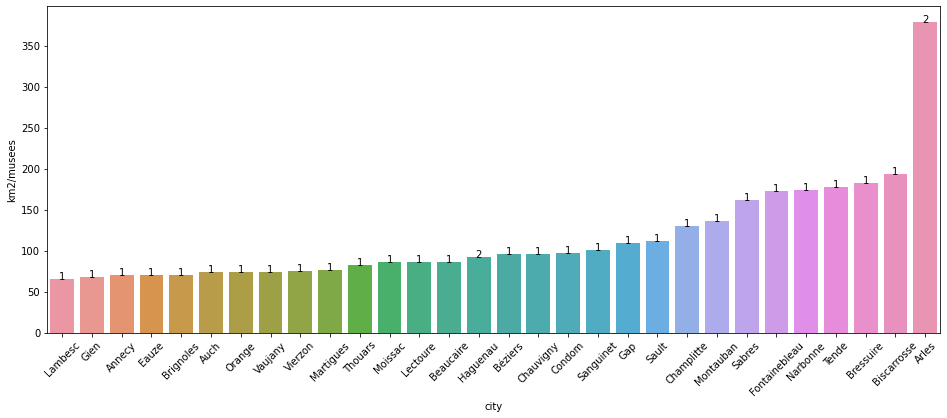

In [30]:
grandes_villes = musee_par_ville_superficie[musee_par_ville_superficie['surf_ha']/100 > 50] # Ville de + de 50km2
grandes_villes = grandes_villes.sort_values('km2/musees')

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="city", y="km2/musees",data=grandes_villes.tail(30))

for item in ax.get_xticklabels():
    item.set_rotation(45)
    
x = 0
for index, row in grandes_villes.tail(30).iterrows():
    ax.text(x, row['km2/musees']-0.3, row.id, color='black', ha="center")
    x = x + 1

Sur ce graphique, tout à droite on retrouve la ville de plus de 50km2 la plus mal loti en terme de rapport surperficie / nombre de musée. Il s'agit donc de Arles dont la superficie est de 756 km2 pour 2 musées, soit un ration de **1 musée tous les 378km2**. Arles est désavantagée du fait de son titre de ville le plus grande de France métropolitenne.

In [31]:
print_stats_ville('Arles')
print()
print_stats_ville('Biscarrosse')
print()
print_stats_ville('Bressuire')

Arles  a un musée pour  378.82  km^2
Superficie de la ville de  Arles  :  757.65 km^2
Liste de ses musées  2  : 
-  musée départemental de l'arles antique
-  musée réattu

Biscarrosse  a un musée pour  193.18  km^2
Superficie de la ville de  Biscarrosse  :  193.18 km^2
Unique musée de la ville : 
-  musée historique de l'hydravion

Bressuire  a un musée pour  182.45  km^2
Superficie de la ville de  Bressuire  :  182.45 km^2
Unique musée de la ville : 
-  musée de bressuire


**Amélioration possible** : Trouver le point, en France, le plus éloigné de tous les musées (Point "Némo").
<a id="frequentation-musees-france"></a>
## Fréquentation des musées français

Afin d'avoir des données pertinentes, nous allons supprimer quelques lignes.

Par exemple, en l'état, nous avons le Musée Promenade Marly/Louveciennes qui a subit une **évolution aberrante de -35000% entre 2016 et 2017**, cette evolution est censé puisque le musée a été [fermé à cause d'une inondation](https://www.leparisien.fr/yvelines-78/marly-le-roi-78160/louveciennes-marly-fermeture-prolongee-pour-le-musee-promenade-24-01-2017-6612555.php) ce qui explique un total de 27 entrées pour 2017.

Cependant, d'autres données sont juste manquante, telles que pour le Cabinet des Estampes et des Dessins dont chaque année il manque soit le nombre d'entrée payant ou gratuite. Ces "fausses" données sont nuisibles.

De façon générale, nous pouvons nous demander quel est le **classement des 10 musées les plus visités** entre 2013 et 2018. Voici la réponse :

In [32]:
#print(len(musee_fr))

#musee_frequentation_groupee= musee_fr.groupby(['id', 'osm_id', 'name','city', 'lat', 'lon']).sum(
#   ['payant','gratuit','total']).reset_index().drop(['year'], axis=1)

# On groupe les musées par id, en espérant que l'ID ne manque pas. Cette méthode est moins efficasse que la méthode appliquées pour le
# dataframe 'distinct_musee_fr'
# Ils devraient apparaitre une fois par an (donc 6 fois au total).
#musee_frequentation_groupee = musee_fr.groupby(['id', 'osm_id', 'name','city', 'lat', 'lon']).agg({'payant': 'sum', 'gratuit': 'sum', 'total': 'sum','country':'count'}).reset_index().rename(columns={'country':'Nombre de lignes groupées'})
musee_frequentation_groupee_stats = musee_fr.groupby(['id']).agg({'payant': 'sum', 'gratuit': 'sum', 'total': 'sum','country':'count'}).reset_index().rename(columns={'country':'Nombre de lignes groupées'})

# On merge ce qu'on a trouvé avec musee_fr pour retrouver le nom, lat, long, ville ... du musée en fonction de son ID
musee_frequentation_groupee = musee_fr.drop(['payant','gratuit','total'], axis=1).merge(musee_frequentation_groupee_stats, on="id")
# On se retrouve avec TOUS les musées (non groupés) ayant le total sur la periode 2013-2018 dans leur ligne, il faut donc garder une seule ligne par musée
musee_frequentation_groupee = musee_frequentation_groupee.drop_duplicates(subset=['id'])

musee_par_frequentation = musee_frequentation_groupee.sort_values('total', ascending=False)
pos = 1
for index, musee in musee_par_frequentation.head(10).iterrows():
    print(pos,':',musee['name'], '(',musee['city'],')')
    pos = pos+1
#print(musee_frequentation_groupee[musee_frequentation_groupee['name'] == 'Musée du Louvre'])

1 : Musée du Louvre ( Paris )
2 : Musée National d'Art Moderne (Centre National d'Art et de Culture Georges Pompidou) ( Le Moulon )
3 : Musée de l'Armée ( Paris )
4 : Musée du Quai Branly - Jacques Chirac ( Paris )
5 : Grande Galerie de l'Evolution (Muséum National d'Histoire Naturelle) ( Paris )
6 : Musée National Auguste Rodin ( Paris )
7 : Musée d'Art Moderne de la ville de Paris ( Paris )
8 : Musée des Civilisations de l'Europe et de la Méditerranée - MuCem ( Marseille )
9 : Musée des Confluences ( Lyon )
10 : Louvre-Lens (collections nationales decentralisées) ( Lens )


**Amélioration possible** : Il y a un delta entre le groupby effectué ici, nous donnant 918 musées, et le travaille effectué sur le dataframe `distinct_musee_fr` qui, lui, présente 824 musées. On pourrait chercher à appliquer le même tri en effectuant des group_by successifs.

Inutile d'afficher ce resultat sur une carte : il est très clair que Paris est grande vainqueuse en terme de volume. On pourrait, là encore, faire un rapporchement avec la superficie mais il en ressortirait que Paris garde ses places dans ce classement.

On va créer un nouvelle colonne dans notre dataset qui représentera l'**évolution de fréquentation par rapport à N-1**.

Quels sont donc les musées qui ont subit les plus grandes évolutions d'une année sur l'autre ?

Voici la liste des musées ayant **subit la plus grosse diminution de fréquentation** par rapport à l'année précédente : 

In [33]:
# 7510709 => Louvre
# On crée une fonction afin de retourner un tuple (payant, gratuit, total) des fréquentations de l'année précédente
# on cherche ces informations dans le dataframe 'musee_fr'
def find_freq_n_moins_1(museeId, annee):
    values = musee_fr[(musee_fr['id'] == museeId) & (musee_fr['year'] == (annee -1))][['payant','gratuit','total']]
    if(values.empty):
        # Si on a pas trouvé l'année dernière, on retourne les chiffres de la même année => évolution = 0%
        return musee_fr[(musee_fr['id'] == museeId) & (musee_fr['year'] == annee)][['payant','gratuit','total']]
    else :
        return values

evo_freq = musee_fr.copy()

# On retire les lignes dont une information 'gratuit' ou 'payant' est égale à 0 (ce qui veut dire que la donnée manque !)
evo_freq = evo_freq[(evo_freq['gratuit'] != 0) & (evo_freq['payant'] != 0)]

# La colonne 'evo_total' contient l'évolution en % par rapport aux entrées de N-1  (VA-VD)/VD*100
evo_freq['evo_total'] = evo_freq.apply(lambda row: ((row['total'] - find_freq_n_moins_1(row['id'], row['year'])['total'].values[0])/row['total'])*100, axis=1)
evo_freq['evo_total'] = evo_freq['evo_total'].round(decimals=2)

In [35]:
classement = evo_freq.sort_values('evo_total', ascending = False)
#classement.head(10)
classement.tail(20)
#classement.iloc[-2]
#print(musee_fr[musee_fr['id'] == '3025801'])

,id,osm_id,name,number,street,postal_code,city,country,country_code,status,lat,lon,year,payant,gratuit,total,geometry,evo_total
2186,0273801,1.736042e+08,Musée de la Résistance et de la Déportation,NaN,Rue Gouillard Marcel,02700,Tergnier,France,fr,open,49.658515,3.315850,2016,3964,1650,5614,POINT (3.31585 49.65851),-235.63
873,2309601,6.222152e+09,Musée d'Art et d'Archéologie,NaN,Route de la Cascade,23400,Bourganeuf,France,fr,open,45.949626,1.756331,2018,353,1834,2187,POINT (1.75633 45.94963),-252.63
2158,1006401,7.820341e+09,Musée Napoléon Ier,NaN,Rue du Maréchal Valée,10500,Brienne-le-Château,France,fr,open,48.389077,4.527967,2016,992,335,1327,POINT (4.52797 48.38908),-259.16
4987,1320401,6.897639e+07,Musée des Beaux-Arts de Marseille,NaN,Rue Édouard Stéphan,13004,Marseille,France,fr,open,43.304596,5.394040,2014,17163,43313,60476,POINT (5.39404 43.30460),-263.78
6775,9531301,2.584778e+09,Musée d'Art et d'Histoire Louis Senlecq,NaN,Grande Rue,95290,L'Isle-Adam,France,fr,open,49.112545,2.215928,2015,424,1248,1672,POINT (2.21593 49.11254),-310.53
5840,3223301,4.777292e+09,Musée Joseph Abeilhé,NaN,Place du Chevalier d'Antras,32230,Marciac,France,fr,open,43.525267,0.161787,2014,25,15,40,POINT (0.16179 43.52527),-312.50
5087,9106401,7.035963e+09,Musée Français de la Photographie,NaN,Rue de Paris,91570,Bièvres,France,fr,open,48.762826,2.225102,2014,2446,6128,8574,POINT (2.22510 48.76283),-346.59
780,1038706,7.312472e+07,Musée d'Art Moderne,NaN,Rue de la Crosse,10000,Troyes,France,fr,open,48.299950,4.082291,2018,8359,687,9046,POINT (4.08229 48.29995),-418.37
2252,1741503,6.710270e+07,Musée Archéologique,NaN,Place Bassompierre,17100,Saintes,France,fr,open,45.745258,-0.628660,2016,964,4641,5605,POINT (-0.62866 45.74526),-420.55
6610,7634101,1.255228e+08,Musée du Prieuré,NaN,Rue du Prieuré,76700,Harfleur,France,fr,open,49.507424,0.201473,2015,181,599,780,POINT (0.20147 49.50742),-451.03


L'on peut observer que le Musée de la Maison Romane (30800) a subit une diminution de fréquentation de 4000%, entre 2016 et 2017 : ce musée a été fermé.

**Amélioration possible** : sil l'on veut exclure les années où un musée a été fermé (pour rénovation par exemple), on pourrait regarder si la fréquentation a fluctuée de manière anormale. Si, par exemple, un musée a une moyenne de 10000 visiteur par année et qu'une année, elle présente un résultat de moins de 500 entrées (seulement 5% de son nombre habituel), on peut alors considérer qu'il y a une situation anormale et on peut décider d'évincer cette donnée.

Liste des visuels à faire :
- Plus grosses évolutions (positives et négatives)
- Comparer les différences de volume au sein d'une même ville (est-ce qu'un musée est délaissé ?)
- Comparer un musée spécifique avec la tendance générale